In [1]:
import data.dataset as dataset

from models.model import HybridNet
from utils.anchors import Anchor
from utils.labels import decode_detection_output, get_detection_labels
from torch.utils.data import Subset
import torch
import torchvision
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from data.dataset import DetectionLabelDataset

In [2]:
detection_class_num = 8
img_size = (375, 1242)
anchor_generator = Anchor(img_size)
detection_datset = DetectionLabelDataset(img_size, anchor_generator.anchors_list, get_detection_labels)
segment_dataset = dataset.SegmentDataset()


In [3]:
img_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(512, interpolation=torchvision.transforms.InterpolationMode.NEAREST)]
)

def segmentation_rescale(X):
    img_batch = []
    label_batch = []
    for img, label in X:
        img = img_transform(img)
        label = img_transform(label)
        img_batch.append(img)
        label_batch.append(label)
    return torch.stack(img_batch,dim=0), torch.stack(label_batch,dim=0)

detection_dataloader = torch.utils.data.DataLoader(detection_datset, shuffle=True, batch_size=8)
segment_dataloader = torch.utils.data.DataLoader(segment_dataset, shuffle=True, batch_size=8, collate_fn = segmentation_rescale)


In [10]:
net = torch.load('trained_model_9.pth')
sample = next(iter(detection_dataloader))
X, y = sample
X = X / 255
preds = net(X.to('cuda'))

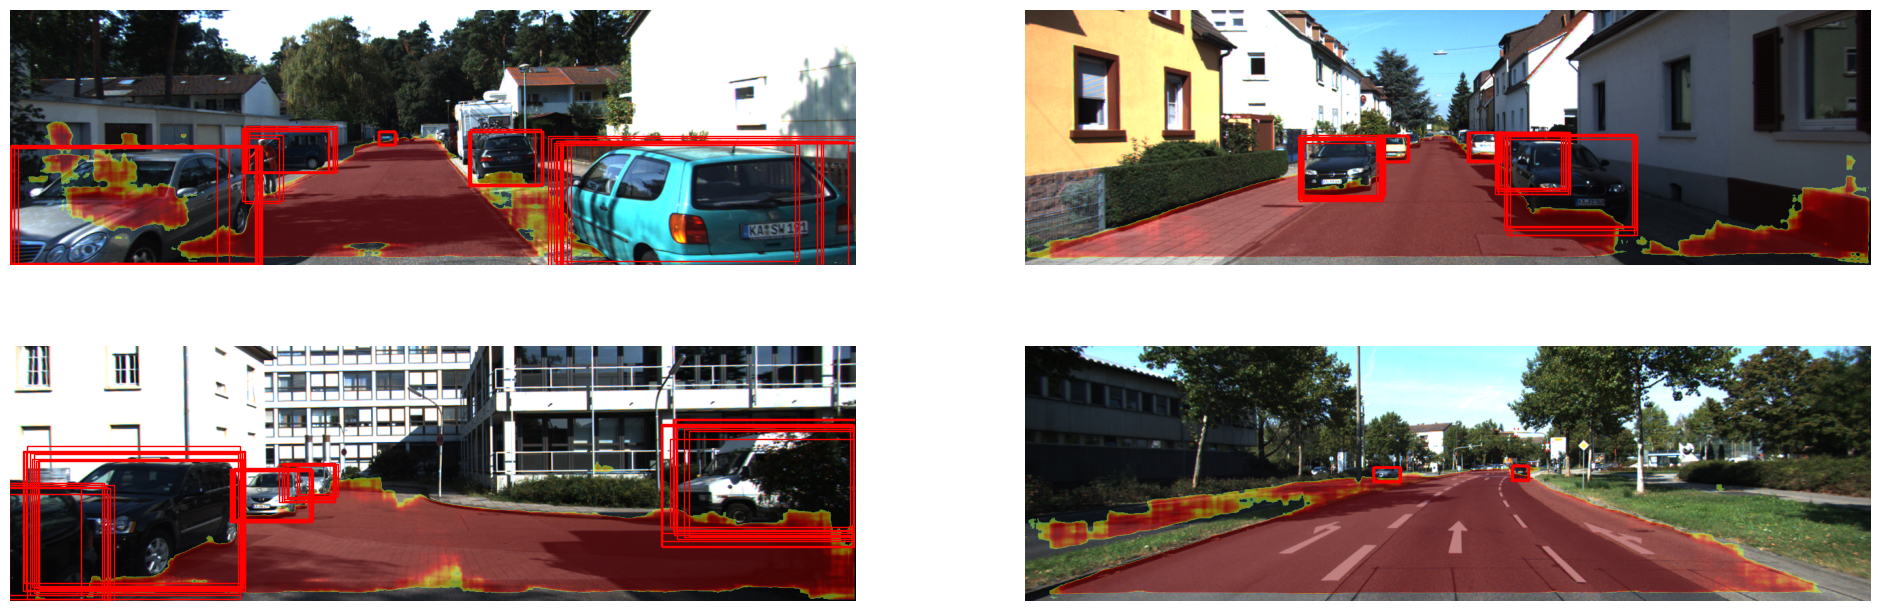

In [12]:
# visualize detection result

anchor_generator = Anchor(img_size)
anchors = list()
for anchor in anchor_generator.anchors_list[3:9]:
    anchor = anchor.reshape(-1,4)
    anchors.append(anchor)
anchors = torch.concatenate(anchors, 0)

def draw_detection_result(idx, preds, ax, anchors):
    p_list = list()
    for p in preds:
        p = torch.permute(p[idx], (2,1,0))
        p = p.reshape(-1, 4 + 1 + detection_class_num)
        p_list.append(p)

    p_list = torch.concatenate(p_list, 0)
    p_list = p_list.to('cpu')
    anchors = anchors.to('cpu')
    cls_output = p_list[:,:-4]
    box_output = p_list[:,-4:]
    box_output = decode_detection_output(anchors, box_output)
    cls_output = torch.softmax(cls_output,1)
    cls_max = torch.max(cls_output, 1)
    cls_max_ids = torch.where(cls_max[1] > 0)

    for ids in cls_max_ids[0]:
        if cls_max[0][ids] > 0.5:
            bb = box_output[ids].to('cpu')
            bb = bb.detach().numpy()
            ax.add_patch(
                patches.Rectangle(
                    (bb[0] - bb[2] / 2, bb[1] - bb[3]/2),
                    bb[2], bb[3],
                    edgecolor='red',
                    facecolor='none'
                )
            )

import cv2
def draw_segmentation_result(idx, preds, ax):
    preds = torchvision.transforms.Resize(img_size)(preds)
    preds = preds.permute(0,2,3,1)
    pred = preds[idx].to('cpu').detach().numpy()
    alpha_mask = pred > 0.5
    # convert jet colormap 
    pred = (1-pred) * 255
    pred = pred.astype(np.uint8)
    pred = cv2.applyColorMap(pred, cv2.COLORMAP_JET)
    pred = pred / 255
    pred = np.concatenate([pred, alpha_mask], axis=-1)
    ax.imshow(pred, alpha = 0.5)
    
fig, ax = plt.subplots(2,2, figsize=(24,8))
for i in range(4):
    img = X[i]
    img = img.permute(1,2,0)
    ax[i%2, i//2].axis('off')
    ax[i%2, i//2].imshow(img.to('cpu'))
    draw_detection_result(i, preds[1], ax[i%2, i//2], anchors)
    draw_segmentation_result(i, preds[0], ax[i%2, i//2])
    
